In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import plotly.express as px

## Project assumptions:
1. Values in collumn 'Collision ID' are unique.
2. Location coordinates are correct.
3. For the purpose of analysis, 'unspecified' contributing factors of accidents are disregarded.
4. The analyzed period is 7 years (from 2012 to 2019).
5. The cause of the accident is a car ‘vehicle type code 1’.

# 3. Data transformation

In [106]:
# Loading the CSV file with vehicle collision data without duplicates and assigning the DataFrame to the variable 'vehicle_collision'
vehicle_collision = pd.read_csv('DataSets/nypd_motor_vehicle_collisions_witout_duplicates.csv', low_memory=False)
pd.set_option('display.max_columns', None)
vehicle_collision.head(10)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-08-05T00:00:00.000,16:30,Queens,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, ...",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN
1,2019-08-27T00:00:00.000,16:02,Brooklyn,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, ...",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,2019-08-15T00:00:00.000,17:57,Manhattan,10002,40.718143,-73.993835,"{'type': 'Point', 'coordinates': [-73.993835, ...",CHRYSTIE STREET,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN
3,2019-08-30T00:00:00.000,21:53,Bronx,10460,40.840534,-73.866610,"{'type': 'Point', 'coordinates': [-73.86661, 4...",NaN,NaN,1837 EAST TREMONT AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4198749,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,2019-08-06T00:00:00.000,9:45,Manhattan,10016,40.745440,-73.975400,"{'type': 'Point', 'coordinates': [-73.9754, 40...",EAST 35 STREET,2 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4183798,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
5,2019-08-29T00:00:00.000,12:28,Brooklyn,11222,40.726524,-73.946390,"{'type': 'Point', 'coordinates': [-73.94639, 4...",NaN,NaN,38 JEWEL STREET,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4196772,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
6,2019-08-31T00:00:00.000,2:16,Queens,11434,40.667522,-73.780630,"{'type': 'Point', 'coordinates': [-73.78063, 4...",ROCKAWAY BOULEVARD,NORTH CONDUIT AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198571,Sedan,NaN,NaN,NaN,NaN
7,2019-08-11T00:00:00.000,22:23,Bronx,NaN,40.858210,-73.916790,"{'type': 'Point', 'coordinates': [-73.91679, 4...",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0.0,1.0,0,0,0,0,0,1,Unsafe Speed,Unspecified,NaN,NaN,NaN,4187134,Motorcycle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
8,2019-08-02T00:00:00.000,16:30,Queens,11434,40.666492,-73.765360,"{'type': 'Point', 'coordinates': [-73.76536, 4...",SOUTH CONDUIT AVENUE,179 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN,4181743,Pick-up Truck,Pick-up Truck,NaN,NaN,NaN
9,2019-08-21T00:00:00.000,17:30,Bronx,10452,40.837720,-73.927630,"{'type': 'Point', 'coordinates': [-73.92763, 4...",WEST 167 STREET,UNIVERSITY AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198173,Sedan,NaN,NaN,NaN,NaN


## Data formatting

In [107]:
# Formatting 'ACCIDENT DATE' to datetime type
vehicle_collision['ACCIDENT DATE'] = pd.to_datetime(vehicle_collision['ACCIDENT DATE'])

In [108]:
# Transforming data to have one collumn 'CONTRIBUTING FACTOR V1-V5' with all contributing factors
vehicle_collision['CONTRIBUTING FACTOR V1-V5'] = vehicle_collision[['CONTRIBUTING FACTOR VEHICLE 1',
                                                                   'CONTRIBUTING FACTOR VEHICLE 2',
                                                                   'CONTRIBUTING FACTOR VEHICLE 3',
                                                                   'CONTRIBUTING FACTOR VEHICLE 4',
                                                                   'CONTRIBUTING FACTOR VEHICLE 5']].values.tolist()

In [109]:
# Exploding factors in a separate rows and assiging to the variable 'vehicle_collision_transformed'
vehicle_collision_transformed = vehicle_collision.explode('CONTRIBUTING FACTOR V1-V5')

In [110]:
# Removing rows without contributing factors
vehicle_collision_transformed = vehicle_collision_transformed.dropna(subset=['CONTRIBUTING FACTOR V1-V5'])
vehicle_collision_transformed.head(10)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CONTRIBUTING FACTOR V1-V5
0,2019-08-05,16:30,Queens,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, ...",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN,Passing Too Closely
0,2019-08-05,16:30,Queens,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, ...",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN,Unspecified
1,2019-08-27,16:02,Brooklyn,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, ...",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Passing Too Closely
1,2019-08-27,16:02,Brooklyn,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, ...",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Unspecified
2,2019-08-15,17:57,Manhattan,10002,40.718143,-73.993835,"{'type': 'Point', 'coordinates': [-73.993835, ...",CHRYSTIE STREET,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN,Driver Inattention/Distraction
3,2019-08-30,21:53,Bronx,10460,40.840534,-73.866610,"{'type': 'Point', 'coordinates': [-73.86661, 4...",NaN,NaN,1837 EAST TREMONT AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4198749,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Unspecified
3,2019-08-30,21:53,Bronx,10460,40.840534,-73.866610,"{'type': 'Point', 'coordinates': [-73.86661, 4...",NaN,NaN,1837 EAST TREMONT AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4198749,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Unspecified
4,2019-08-06,9:45,Manhattan,10016,40.745440,-73.975400,"{'type': 'Point', 'coordinates': [-73.9754, 40...",EAST 35 STREET,2 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4183798,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Driver Inattention/Distraction
4,2019-08-06,9:45,Manhattan,10016,40.745440,-73.975400,"{'type': 'Point', 'coordinates': [-73.9754, 40...",EAST 35 STREET,2 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4183798,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Driver Inattention/Distraction
5,2019-08-29,12:28,Brooklyn,11222,40.726524,-73.946390,"{'type': 'Point', 'coordinates': [-73.94639, 4...",NaN,NaN,38 JEWEL STREET,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4196772,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,Unspecified


In [111]:
# Capitalizing each entry in 'CONTRIBUTING FACTOR V1-V5'
vehicle_collision_transformed.loc[:, 'CONTRIBUTING FACTOR V1-V5'] = vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].str.upper()

In [112]:
# Removing factors which are 'Unspecified' in 'CONTRIBUTING FACTOR V1-V5' collumn
vehicle_collision_transformed = vehicle_collision_transformed[vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'] != 'UNSPECIFIED']
# vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].unique()

## Removing errors

In [113]:
# Removing human entry errors ('Illnes' -> 'Illness')
vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'] = vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].replace('ILLNES', 'ILLNESS')

# 4. Data analysis and results presentation

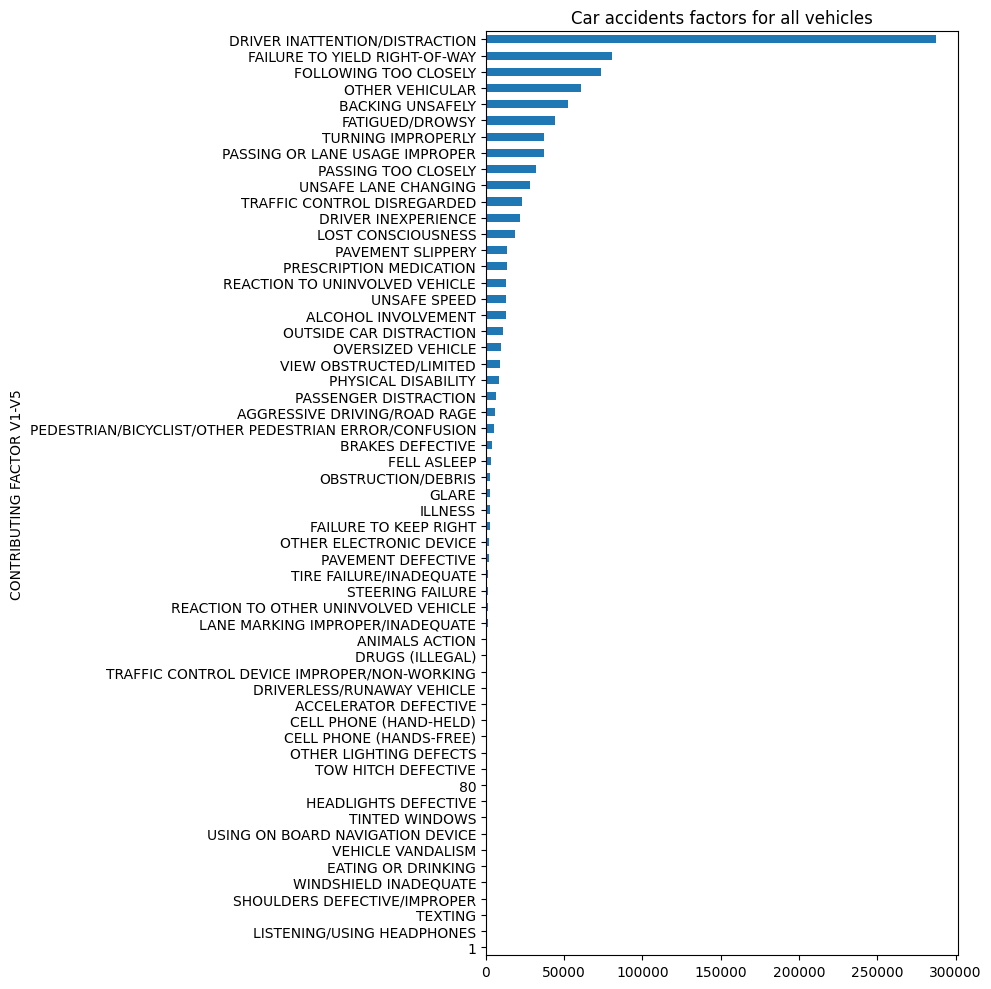

In [114]:
# Graphical visualization of car accidents factors for vehicles
plt.figure(figsize=(10, 10))
vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Car accidents factors for all vehicles')
plt.tight_layout()
plt.show()

## 4.1 Most dangerous factors by borough

In [115]:
# Selecting only rows with 'NUMBER OF PERSONS KILLED'
persons_killed_data = vehicle_collision_transformed.groupby(['BOROUGH', 'CONTRIBUTING FACTOR V1-V5'])[['NUMBER OF PERSONS KILLED']].sum()
persons_killed_data = persons_killed_data.groupby('BOROUGH').apply(lambda x: x.sort_values(by='NUMBER OF PERSONS KILLED', ascending=False).head(3))
persons_killed_data = persons_killed_data.reset_index(level=1, drop=False)
persons_killed_data

BOROUGH  \
BOROUGH       CONTRIBUTING FACTOR V1-V5                                           
Bronx         DRIVER INATTENTION/DISTRACTION                              Bronx   
              UNSAFE SPEED                                                Bronx   
              TRAFFIC CONTROL DISREGARDED                                 Bronx   
Brooklyn      DRIVER INATTENTION/DISTRACTION                           Brooklyn   
              TRAFFIC CONTROL DISREGARDED                              Brooklyn   
              FAILURE TO YIELD RIGHT-OF-WAY                            Brooklyn   
Manhattan     DRIVER INATTENTION/DISTRACTION                          Manhattan   
              FAILURE TO YIELD RIGHT-OF-WAY                           Manhattan   
              PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CON...      Manhattan   
Queens        TRAFFIC CONTROL DISREGARDED                                Queens   
              UNSAFE SPEED                                               Queens   
              DRIVER INATTENTION/DISTRACTION                             Queens   
Staten Island DRIVER INATTENTION/DISTRACTION                      Staten Island   
              UNSAFE SPEED                                        Staten Island   
              TRAFFIC CONTROL DISREGARDED                         Staten Island   
UNKNOWN       DRIVER INATTENTION/DISTRACTION                            UNKNOWN   
              TRAFFIC CONTROL DISREGARDED                               UNKNOWN   
              UNSAFE SPEED                                              UNKNOWN   

                                                                  NUMBER OF PERSONS KILLED  
BOROUGH       CONTRIBUTING FACTOR V1-V5                                                     
Bronx         DRIVER INATTENTION/DISTRACTION                                          26.0  
              UNSAFE SPEED                                                            18.0  
              TRAFFIC CONTROL DISREGARDED                                             15.0  
Brooklyn      DRIVER INATTENTION/DISTRACTION                                          53.0  
              TRAFFIC CONTROL DISREGARDED                                             40.0  
              FAILURE TO YIELD RIGHT-OF-WAY                                           37.0  
Manhattan     DRIVER INATTENTION/DISTRACTION                                          37.0  
              FAILURE TO YIELD RIGHT-OF-WAY                                           30.0  
              PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CON...                      14.0  
Queens        TRAFFIC CONTROL DISREGARDED                                             49.0  
              UNSAFE SPEED                                                            47.0  
              DRIVER INATTENTION/DISTRACTION                                          43.0  
Staten Island DRIVER INATTENTION/DISTRACTION                                          13.0  
              UNSAFE SPEED                                                            12.0  
              TRAFFIC CONTROL DISREGARDED                                              7.0  
UNKNOWN       DRIVER INATTENTION/DISTRACTION                                          27.0  
              TRAFFIC CONTROL DISREGARDED                                             18.0  
              UNSAFE SPEED                                                            11.0

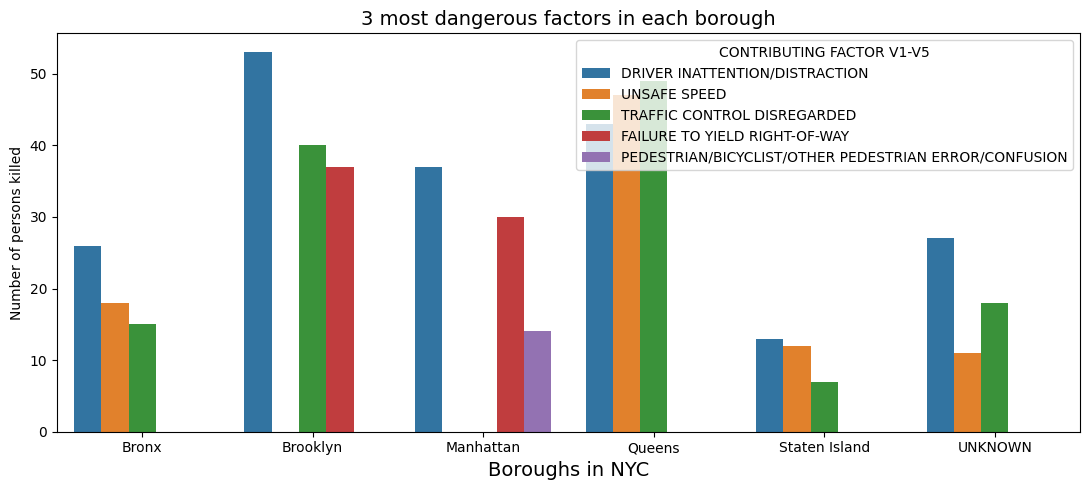

In [116]:
# Data visualization using seaborn as sns
plt.figure(figsize=(11,5))
sns.barplot(x='BOROUGH', y='NUMBER OF PERSONS KILLED', hue='CONTRIBUTING FACTOR V1-V5', data=persons_killed_data)
plt.title('3 most dangerous factors in each borough', fontsize=14)
plt.xlabel('Boroughs in NYC', fontsize=14)
plt.ylabel('Number of persons killed')
plt.tight_layout()
plt.show()

## 4.2 Impact of speeding

In [117]:
# Selecting only rows with 'UNSAFE SPEED' factor
unsafe_speed_data = vehicle_collision_transformed[vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'] == 'UNSAFE SPEED']
# Grouping data by borough and summing up deaths and injuries
unsafe_speed_data = unsafe_speed_data.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
unsafe_speed_data

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
BOROUGH,,
Bronx,1584.0,18.0
Brooklyn,2120.0,23.0
Manhattan,707.0,10.0
Queens,2336.0,47.0
Staten Island,435.0,12.0
UNKNOWN,951.0,11.0


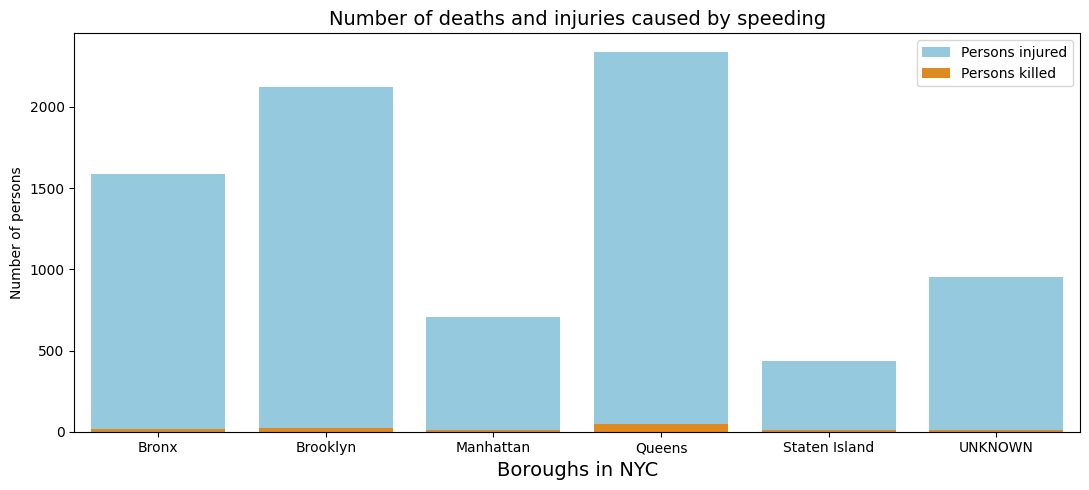

In [118]:
# Data visualization using seaborn as sns
plt.figure(figsize=(11,5))
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS INJURED', color='skyblue', label='Persons injured')
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS KILLED', color='darkorange', label='Persons killed')
plt.title('Number of deaths and injuries caused by speeding', fontsize=14)
plt.xlabel('Boroughs in NYC', fontsize=14)
plt.ylabel('Number of persons')
plt.tight_layout()
plt.show()

In [119]:
# Another data visualization
fig = plt.figure(figsize=(10,6))
unsafe_speed_data.plot(kind='bar')
plt.title('Number of deaths and injuries caused by speeding')
plt.xlabel('Borough in NYC')
plt.ylabel('Number of persons')
plt.tight_layout()
plt.savefig('DataSets/Number_of_deaths_and_injuries.png')
plt.close()
# Showing graph on the middle of the screen
HTML("""
<div style="display: flex; justify-content: center;">
    <img src="DataSets/Number_of_deaths_and_injuries.png" alt="Wykres">
</div>
""")

<Figure size 1000x600 with 0 Axes>

In [120]:
# Summing numbers of persons killed and injured by unsafe speeding
unsafe_speed_data = unsafe_speed_data[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
unsafe_speed_data

NUMBER OF PERSONS INJURED    8133.0
NUMBER OF PERSONS KILLED      121.0
dtype: float64

## 4.3 Top 3 accident factors

In [121]:
# Grouping dataframe by 'BOROUGH' and 'CONTRIBUTING FACTOR V1-V5'
most_dangerous_factors = vehicle_collision_transformed.groupby(['BOROUGH','CONTRIBUTING FACTOR V1-V5']).size()
# Grouping by 'n largest' contributing factors 
most_dangerous_factors = most_dangerous_factors.groupby(level=0).nlargest(3).reset_index(level=0, drop=True) # you can change nlargest to different values
# Data visualization (data type: 'series')
most_dangerous_factors

BOROUGH        CONTRIBUTING FACTOR V1-V5     
Bronx          DRIVER INATTENTION/DISTRACTION    30522
               OTHER VEHICULAR                   10279
               FOLLOWING TOO CLOSELY              9376
Brooklyn       DRIVER INATTENTION/DISTRACTION    63924
               FAILURE TO YIELD RIGHT-OF-WAY     22395
               FOLLOWING TOO CLOSELY             15915
Manhattan      DRIVER INATTENTION/DISTRACTION    67513
               OTHER VEHICULAR                   23093
               FAILURE TO YIELD RIGHT-OF-WAY     13022
Queens         DRIVER INATTENTION/DISTRACTION    78657
               FAILURE TO YIELD RIGHT-OF-WAY     26233
               FOLLOWING TOO CLOSELY             21086
Staten Island  DRIVER INATTENTION/DISTRACTION    14132
               FAILURE TO YIELD RIGHT-OF-WAY      3302
               FOLLOWING TOO CLOSELY              3057
UNKNOWN        DRIVER INATTENTION/DISTRACTION    32671
               FOLLOWING TOO CLOSELY             12136
               FATI

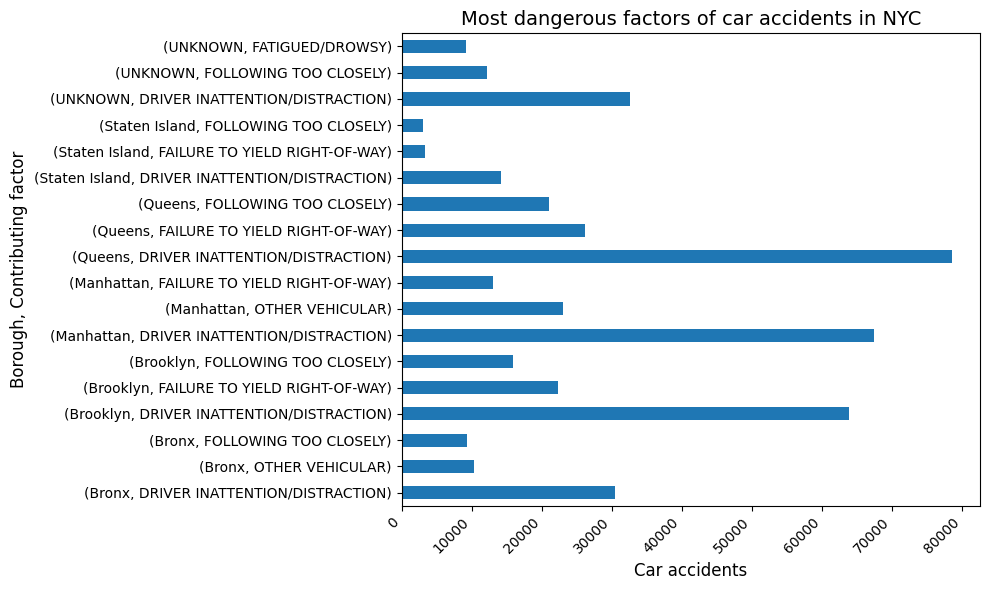

In [122]:
# Graphical visualization of most dangerous factors of car accidents in NYC
plt.figure(figsize = (10,6))
most_dangerous_factors.plot(kind='barh')
plt.title('Most dangerous factors of car accidents in NYC', fontsize=14)
plt.ylabel('Borough, Contributing factor', fontsize = 12)
plt.xlabel('Car accidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.4 Vehicle type

In [123]:
# Changing the values for columns with vehicle type to upper case
columns_to_upper = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
vehicle_collision[columns_to_upper] = vehicle_collision[columns_to_upper].apply(lambda col: col.str.upper())

In [124]:
# Combining information from the columns VEHICLE TYPE CODE 1 to VEHICLE TYPE CODE 5 into a single series
vehicle_collision_vehicle_types = pd.concat([
    vehicle_collision['VEHICLE TYPE CODE 1'],
    vehicle_collision['VEHICLE TYPE CODE 2'],
    vehicle_collision['VEHICLE TYPE CODE 3'],
    vehicle_collision['VEHICLE TYPE CODE 4'],
    vehicle_collision['VEHICLE TYPE CODE 5']
])

In [125]:
# Standardizing the naming of certain vehicles
vehicle_collision_vehicle_types = vehicle_collision_vehicle_types.replace('STATION WAGON/SPORT UTILITY VEHICLE', 'SPORT UTILITY / STATION WAGON')

In [126]:
# Counting unique types of vehicles
vehicle_counts = vehicle_collision_vehicle_types.value_counts()
vehicle_counts.head(10)

PASSENGER VEHICLE                985909
SPORT UTILITY / STATION WAGON    647064
SEDAN                            232358
TAXI                              98155
UNKNOWN                           77617
PICK-UP TRUCK                     53793
VAN                               42947
OTHER                             37070
BUS                               29135
BICYCLE                           25399
Name: count, dtype: int64

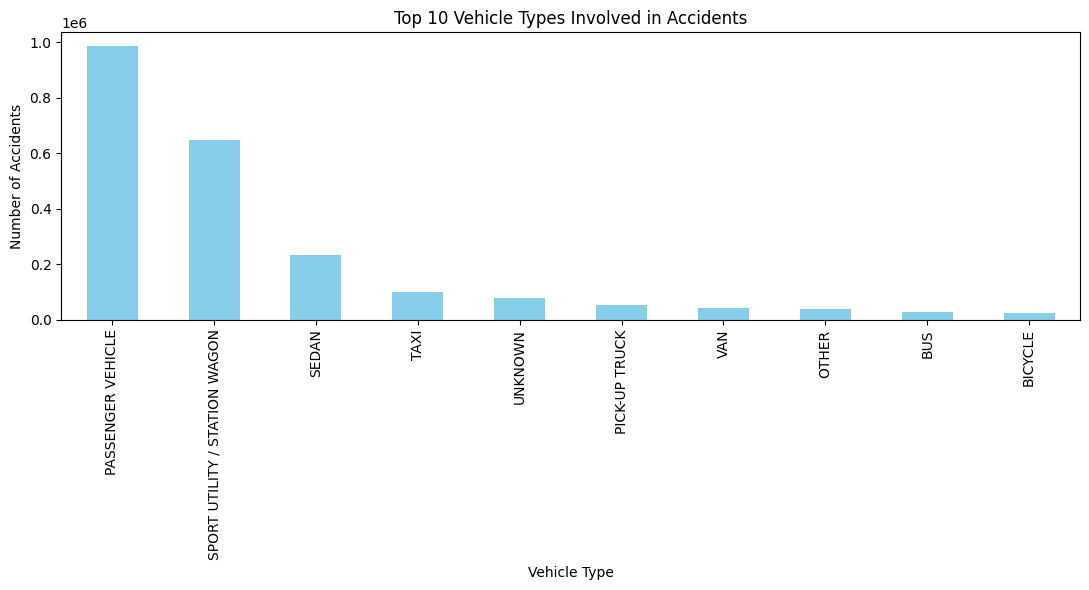

In [127]:
# Data visualization - vehicle type
vehicle_counts.head(10).plot(kind='bar', figsize=(11, 6), color='skyblue')
plt.title('Top 10 Vehicle Types Involved in Accidents')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 4.5 Accident statistics by borough

In [128]:
# Statistics for each borough 
borough_stats = vehicle_collision_transformed.groupby('BOROUGH')[['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']].agg(['sum', 'mean', 'max'])
borough_stats

NUMBER OF PERSONS KILLED                 \
                                   sum      mean  max   
BOROUGH                                                 
Bronx                            142.0  0.001271  3.0   
Brooklyn                         250.0  0.001134  3.0   
Manhattan                        158.0  0.000730  8.0   
Queens                           269.0  0.001118  5.0   
Staten Island                     55.0  0.001382  3.0   
UNKNOWN                          123.0  0.001022  2.0   

              NUMBER OF PERSONS INJURED                  
                                    sum      mean   max  
BOROUGH                                                  
Bronx                           38241.0  0.342177  24.0  
Brooklyn                        70293.0  0.318974  24.0  
Manhattan                       39776.0  0.183845  27.0  
Queens                          71657.0  0.297852  16.0  
Staten Island                   11364.0  0.285470  17.0  
UNKNOWN                         34811.0  0.289166  31.0

In [129]:
# Total number of victims
sum_stats = borough_stats.xs('sum', level=1, axis=1).reset_index()
# Interactive plot using plotly.express
fig = px.bar(
    sum_stats,
    x='BOROUGH',
    y=['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'],
    title='Total number of victims in boroughs',
    labels={'value': 'Number of people', 'variable': 'Victim type'},
    barmode='group'
)
fig.show()

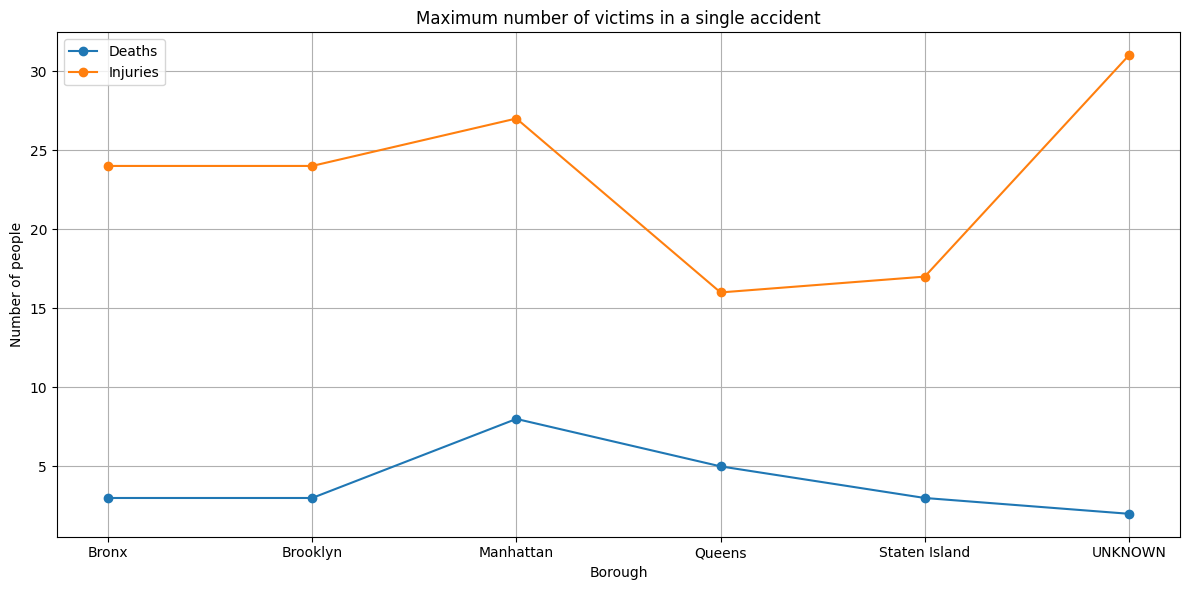

In [130]:
# Extract the maximum for each borough
max_stats = borough_stats.xs('max', level=1, axis=1)

# Line plot 
max_stats.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Maximum number of victims in a single accident')
plt.xlabel('Borough')
plt.ylabel('Number of people')
plt.legend(['Deaths', 'Injuries'])
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.6 Frequent accident locations (optional)

In [131]:
# Removing coordinates with values 0x0
vehicle_collision_transformed = vehicle_collision_transformed[
    (vehicle_collision_transformed['LATITUDE'] != 0.000000) & 
    (vehicle_collision_transformed['LONGITUDE'] != 0.000000)
]

In [132]:
# Aggregating the number of accidents at different points
accidents_by_location = vehicle_collision_transformed.groupby(['LATITUDE', 'LONGITUDE']).size().reset_index(name='ACCIDENT_COUNT')

# Showing first 10 results
print(accidents_by_location.head(10))

    LATITUDE  LONGITUDE  ACCIDENT_COUNT
0  30.784180 -89.135270               1
1  40.499479 -74.241728               2
2  40.499840 -74.239920               1
3  40.499842 -74.239917               1
4  40.500023 -74.239020               1
5  40.500084 -74.238690               1
6  40.501522 -74.242430               1
7  40.501630 -74.244354               1
8  40.501762 -74.235149               1
9  40.501977 -74.242589               4


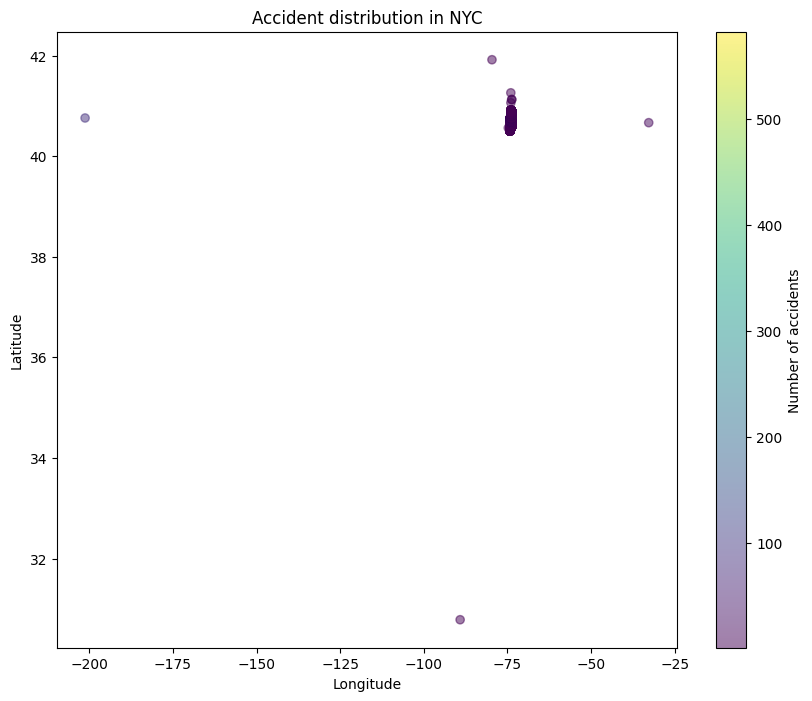

In [133]:
# Scatter plot for geographical coordinates
plt.figure(figsize=(10, 8))
plt.scatter(accidents_by_location['LONGITUDE'], accidents_by_location['LATITUDE'], c=accidents_by_location['ACCIDENT_COUNT'], cmap='viridis', alpha=0.5)
plt.title('Accident distribution in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Number of accidents')
plt.show()

# 5. Conclusions

1.	The most common factor of accidents in NYC is: ‘Driver inattention/distraction.’ It is also the most frequent cause of accidents in each borough.
2.	Considering accidents resulting in fatalities, the most dangerous cause of accidents across NYC is also ‘Driver inattention/distraction’. This factor led to the deaths of 199 people in NYC during the analyzed period. It is also a leading cause in nearly all boroughs, except Queens. In Queens, most fatalities were caused by ‘Traffic control disregarded’ (49) and ‘Unsafe speed’ (47).
3.	Unsafe speed caused 121 deaths and injured 8133 people during the analyzed period. Unsafe speed ranks as the fourth leading cause of fatalities. The first is ‘Driver inattention/distraction’, followed by ‘Traffic control disregarded’ and ‘Failure to yield right-of-way’.
4.	The type of vehicle most frequently involved in accidents is: ‘Passenger vehicle’, followed by ‘Sport utility/station wagon’, ‘Sedan’ and ‘Taxi’.
5.	The highest number of accidents occurred in the districts of Queens and Brooklyn, while the accident with the highest number of fatalities occurred in the Manhattan district (8 people killed), as well as the highest number of injuries (27 people injured).